In [492]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
all_metrics = {
    'dataset_01': {'kmeans': {}, 'dbscan': {}},
    'dataset_02': {'kmeans': {}, 'dbscan': {}},
    'dataset_03': {'kmeans': {}, 'dbscan': {}}
}
best_configs = {    'dataset_01': {},
    'dataset_02': {},
    'dataset_03': {}}



In [493]:
def compute_dbscan_metrics(X, eps, min_samples):
    """Считает правильные метрики для DBSCAN"""
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.mean(labels == -1) * 100
    
    if n_clusters > 1:
        non_noise = labels != -1
        silhouette = silhouette_score(X[non_noise], labels[non_noise])
        db_score = davies_bouldin_score(X[non_noise], labels[non_noise])
        ch_score = calinski_harabasz_score(X[non_noise], labels[non_noise])
    else:
        silhouette = db_score = ch_score = np.nan
    
    return {
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'noise_%': noise_ratio,
        'silhouette': silhouette,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }
def kmeans_composite_score(sil, db, ch, inertia, weights=None):
    """
    Композитный score для KMeans
    
    weights: [sil_weight, db_weight, ch_weight, inertia_weight]
    По умолчанию: [0.4, 0.3, 0.2, 0.1]
    """
    if weights is None:
        weights = [0.4, 0.3, 0.2, 0.1]
    
    # Нормализуем метрики в [0, 1]
    sil_norm = (sil - sil.min()) / (sil.max() - sil.min() + 1e-10)
    db_norm = 1 - (db - db.min()) / (db.max() - db.min() + 1e-10)  # инвертируем: чем меньше DB, тем лучше
    ch_norm = (ch - ch.min()) / (ch.max() - ch.min() + 1e-10)
    inertia_norm = 1 - (inertia - inertia.min()) / (inertia.max() - inertia.min() + 1e-10)  # инвертируем
    
    # Композитный score
    composite = (sil_norm * weights[0] + 
                 db_norm * weights[1] + 
                 ch_norm * weights[2] + 
                 inertia_norm * weights[3])
    
    return composite, sil_norm, db_norm, ch_norm, inertia_norm

# ИСПОЛЬЗОВАНИЕ:
# sil, db, ch, inertia = compute_metrics_over_k(X, k_values)
# composite, sil_norm, db_norm, ch_norm, inertia_norm = kmeans_composite_score(sil, db, ch, inertia)

# Лучшее k:
# best_k_idx = np.argmax(composite)
# best_k = k_values[best_k_idx]
def print_dbscan_metrics(X, eps, min_samples, labels, n_clusters):
    """
    Вывод метрик для DBSCAN
    
    Parameters:
    X - данные (масштабированные)
    eps, min_samples - параметры DBSCAN
    labels - метки кластеров (-1 = шум)
    n_clusters - число кластеров (без учёта шума)
    """
    
    # Разделяем шум и кластеры
    noise_mask = labels == -1
    noise_ratio = np.mean(noise_mask)
    
    # Метрики считаем только для не-шума
    if n_clusters > 1:
        X_non_noise = X[~noise_mask]
        labels_non_noise = labels[~noise_mask]
        
        sil = silhouette_score(X_non_noise, labels_non_noise)
        db = davies_bouldin_score(X_non_noise, labels_non_noise)
        ch = calinski_harabasz_score(X_non_noise, labels_non_noise)
    else:
        sil = db = ch = np.nan
    
    print("="*50)
    print(f"DBSCAN с eps={eps}, min_samples={min_samples} - РЕЗУЛЬТАТЫ:")
    print("="*50)
    print(f"Кластеров: {n_clusters}")
    print(f"Шум: {noise_ratio:.1%} ({np.sum(noise_mask)} точек)")
    print(f"Silhouette: {sil:.4f}" if not np.isnan(sil) else "Silhouette: NaN")
    print(f"Davies-Bouldin: {db:.4f}" if not np.isnan(db) else "Davies-Bouldin: NaN")
    print(f"Calinski-Harabasz: {ch:.0f}" if not np.isnan(ch) else "Calinski-Harabasz: NaN")
    print("="*50)
    
def evaluate_k_range(X, k_values, scale=False, random_state=RANDOM_STATE):
    # Для заданных K считает:
    # - inertia_ (ниже лучше)
    # - silhouette_score (выше лучше; определён для K>=2)
    #
    # Возвращает словарь с массивами метрик.
    X_work = X
    if scale:
        scaler = StandardScaler()
        X_work = scaler.fit_transform(X_work)

    inertias = []
    silhouettes = []

    for k in k_values:
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = model.fit_predict(X_work)

        inertias.append(model.inertia_)
        # silhouette определён только если кластеров >= 2 и есть хотя бы 2 разных кластера
        if k >= 2 and len(np.unique(labels)) > 1:
            silhouettes.append(silhouette_score(X_work, labels))
        else:
            silhouettes.append(np.nan)

    return {
        "k": np.array(list(k_values), dtype=int),
        "inertia": np.array(inertias, dtype=float),
        "silhouette": np.array(silhouettes, dtype=float),
        "scaled": bool(scale),
    }

def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

def kmeans_labels(X, k, random_state=RANDOM_STATE):
    # n_init='auto' – современный режим в sklearn; на старых версиях может потребоваться n_init=10
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        return model.fit_predict(X)

def compute_metrics_over_k(X, k_values):
    sil = []
    db = []
    ch = []
    inertia = []

    for k in k_values:
        labels = kmeans_labels(X, k)

        sil.append(silhouette_score(X, labels))
        db.append(davies_bouldin_score(X, labels))
        ch.append(calinski_harabasz_score(X, labels))

        # Для "локтя" (elbow) – полезно иметь inertia
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(X)
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10).fit(X)
        inertia.append(model.inertia_)

    return np.array(sil), np.array(db), np.array(ch), np.array(inertia)
def print_k_metrics(X,K, labels, model):
    sil_k = silhouette_score(X, labels)
    db_k = davies_bouldin_score(X, labels)
    ch_k = calinski_harabasz_score(X, labels)
    inertia_k = model.inertia_

    print("="*50)
    print(f"KMeans с k={K} - РЕЗУЛЬТАТЫ:")
    print("="*50)
    print(f"Silhouette score: {sil_k:.4f}")
    print(f"Davies-Bouldin index: {db_k:.4f}")
    print(f"Calinski-Harabasz score: {ch_k:.0f}")
    print(f"Inertia (WCSS): {inertia_k:.0f}")
    print("="*50)


In [494]:
scaler = StandardScaler()
def preproc(csv_path:str):
    df = pd.read_csv(csv_path)
    id = df[df.columns[0]]
    X = df.drop(columns = [df.columns[0]])
    X_numeric = X.select_dtypes(include=[np.number]).columns.to_list()
    X_cat = X.select_dtypes(exclude=[np.number]).columns.to_list()
    transform = []
    if X_numeric:
            numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
            transform.append(('numeric', numeric_pipeline, X_numeric))
    if X_cat:
        transform.append(('categorial', SimpleImputer(strategy='most_frequent'), X_cat))
    preprocessor = ColumnTransformer(transformers=transform)

    X_preprocessed = preprocessor.fit_transform(X)

    return id, pd.DataFrame(X_preprocessed)

# Работа с 1 датасетом

In [495]:
df = pd.read_csv("./data/S07-hw-dataset-01.csv")
df.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [496]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [497]:
df.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


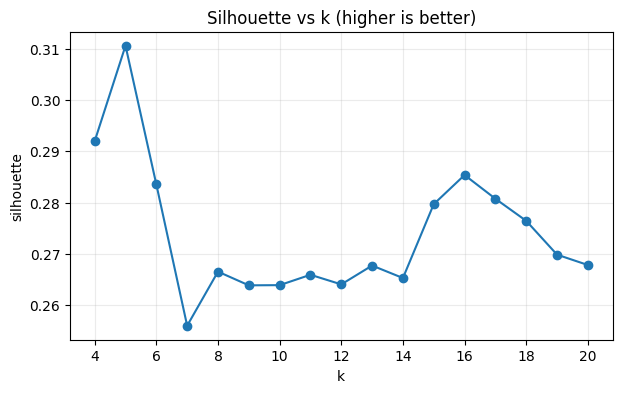

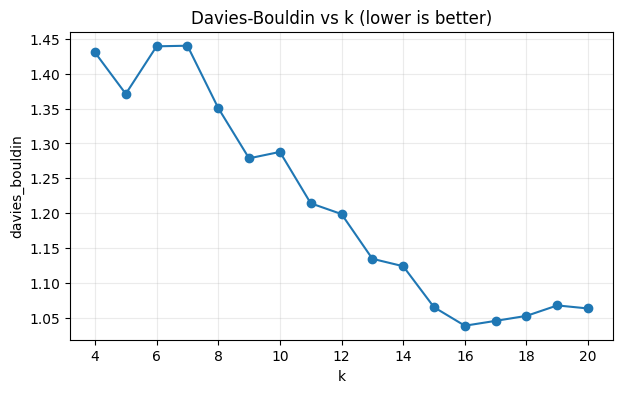

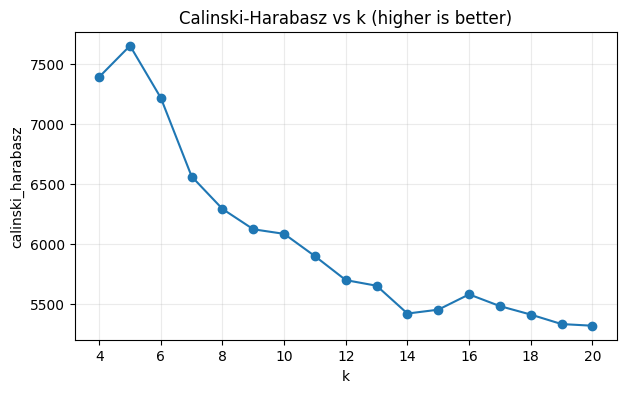

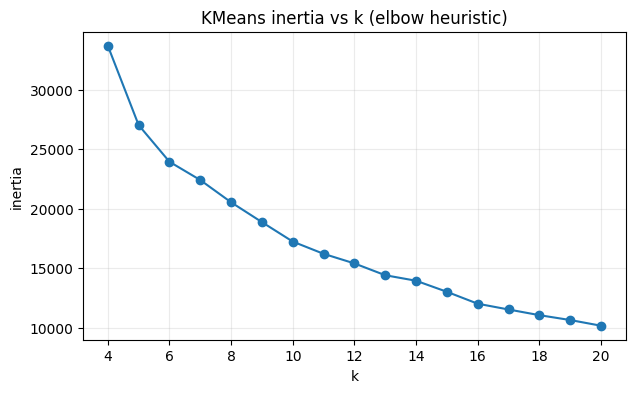

In [498]:

#Метод K_means
id, X = preproc("./data/S07-hw-dataset-01.csv")
k_values = list(range(4, 21))
sil, db, ch, inertia = compute_metrics_over_k(X, k_values)
# Визуализируем внутренние метрики + "локоть"
plt.figure(figsize=(7, 4))
plt.plot(k_values, sil, marker="o")
plt.title("Silhouette vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/Silhouette_vs_k_01.png', dpi=100)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, db, marker="o")
plt.title("Davies-Bouldin vs k (lower is better)")
plt.xlabel("k")
plt.ylabel("davies_bouldin")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, ch, marker="o")
plt.title("Calinski-Harabasz vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("calinski_harabasz")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, inertia, marker="o")
plt.title("KMeans inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.show()


Для данного датасета выберем K = 5, при нем инерция равна около 26000, при этом довольно высокий силуэт - 0.31, при этом неплохие показатели 
davies_bouldin_score
calinski_harabasz_score


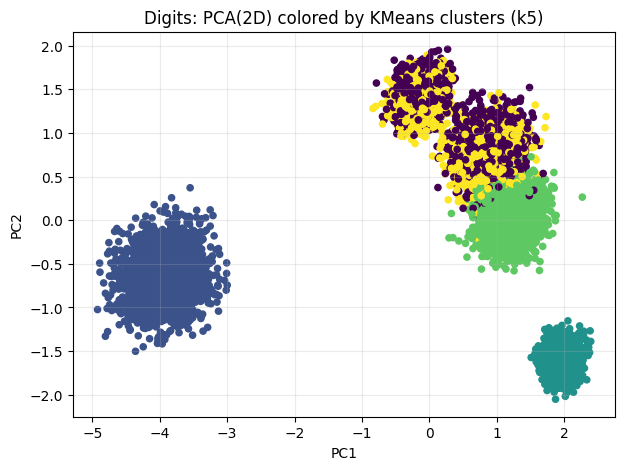

KMeans с k=5 - РЕЗУЛЬТАТЫ:
Silhouette score: 0.3548
Davies-Bouldin index: 1.2737
Calinski-Harabasz score: 8301
Inertia (WCSS): 25476


In [499]:
K = 5
model = KMeans(n_clusters=K,n_init=10,random_state=RANDOM_STATE)
labels = model.fit_predict(X)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, s=20)
plt.title(f"Digits: PCA(2D) colored by KMeans clusters (k{K})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.show()
sil_k6 = silhouette_score(X, labels)
db_k6 = davies_bouldin_score(X, labels)
ch_k6 = calinski_harabasz_score(X, labels)
inertia_k6 = model.inertia_

print_k_metrics(X,K,labels,model)


In [500]:
def grid_search_dbscan_simple(X, eps_list=[0.1, 0.3, 0.5, 0.7, 1.0], min_samples_list=[3, 5, 6, 7]):
    results = []
    
    for eps in eps_list:
        for min_samples in min_samples_list:
            # 1. Обучаем DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X)
            
            # 2. Считаем статистику
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            noise_mask = labels == -1
            noise_ratio = np.mean(noise_mask)
            
            # 3. Метрики
            if n_clusters > 1 and noise_ratio < 0.7:
                X_non_noise = X[~noise_mask]
                labels_non_noise = labels[~noise_mask]
                
                silhouette = silhouette_score(X_non_noise, labels_non_noise)
                db_score = davies_bouldin_score(X_non_noise, labels_non_noise)
                ch_score = calinski_harabasz_score(X_non_noise, labels_non_noise)
            else:
                silhouette = db_score = ch_score = np.nan
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_%': noise_ratio * 100,
                'silhouette': silhouette,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score,
                'labels': labels  
            })
    
    df = pd.DataFrame(results)
    
    # 5. Находим лучшие параметры
    valid_df = df.dropna()
    
    if len(valid_df) > 0:
        # Фильтруем разумные варианты
        filtered = valid_df[(valid_df['noise_%'] < 40) & 
                           (valid_df['n_clusters'] >= 3) & 
                           (valid_df['n_clusters'] <= 10) &
                           (valid_df['silhouette'] > 0.2) &
                           (valid_df['eps'] < 1.0)]
        
        if len(filtered) > 0:
            df_to_score = filtered.copy()
        else:
            df_to_score = valid_df.copy()
        
        # НОРМАЛИЗАЦИЯ
        scaler = StandardScaler()
        sil_scaled = scaler.fit_transform(df_to_score[['silhouette']]).flatten()
        db_scaled = -scaler.fit_transform(df_to_score[['davies_bouldin']].values.reshape(-1, 1)).flatten()
        ch_scaled = scaler.fit_transform(df_to_score[['calinski_harabasz']].values.reshape(-1, 1)).flatten()
        noise_scaled = -scaler.fit_transform(df_to_score[['noise_%']].values.reshape(-1, 1)).flatten()

        # Композитный score
        df_to_score['composite_score'] = (
            sil_scaled * 0.25 + db_scaled * 0.25 + 
            ch_scaled * 0.25 + noise_scaled * 0.25
        )
        
        # Выбираем лучший
        best_idx = df_to_score['composite_score'].idxmax()
        best_row = df_to_score.loc[best_idx]
        
        # ВЫВОДИМ МЕТРИКИ
        print_dbscan_metrics(
            X=X,
            eps=best_row['eps'],
            min_samples=int(best_row['min_samples']),
            labels=best_row['labels'],
            n_clusters=int(best_row['n_clusters'])
        )
        
        return best_row, df
    
    print("Нет валидных результатов")
    return None, df



In [501]:
# ИСПОЛЬЗОВАНИЕ:
eps_list = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_list = [3, 5,6, 7]

best_params, results_df = grid_search_dbscan_simple(X, eps_list, min_samples_list)



DBSCAN с eps=0.7, min_samples=3 - РЕЗУЛЬТАТЫ:
Кластеров: 5
Шум: 0.3% (36 точек)
Silhouette: 0.3792
Davies-Bouldin: 1.2631
Calinski-Harabasz: 8331


In [502]:
# Обучаем финальную модель с лучшими параметрами
if best_params is not None:
    db_best = DBSCAN(eps=best_params['eps'], 
                     min_samples=int(best_params['min_samples']))
    labels_best = db_best.fit_predict(X)

df['label'] = labels_best
df.to_csv('artifacts/labels/labels_ hw07_ds1.csv', index=False)

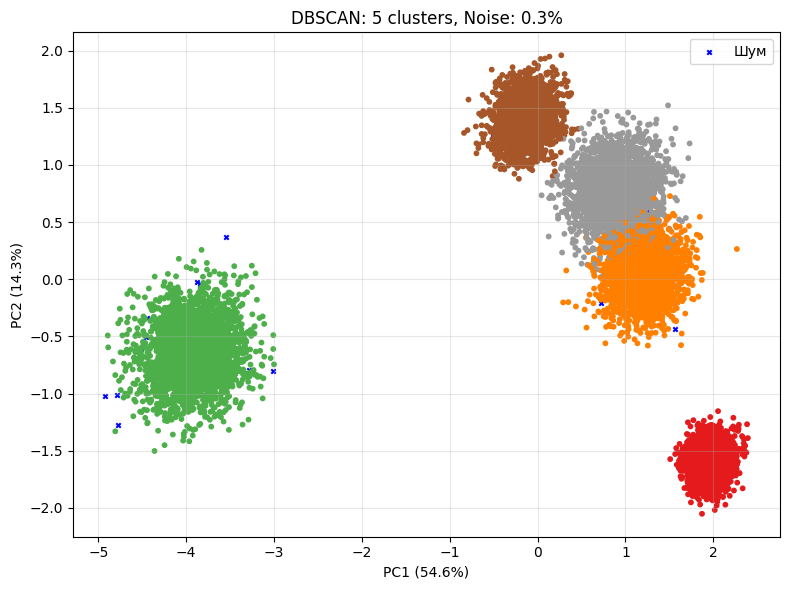

In [503]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))

# Шум
noise = labels_best == -1
if noise.any():
    plt.scatter(X_pca[noise, 0], X_pca[noise, 1], c='blue', s=10, marker='x', alpha=1, label='Шум')

# Кластеры
clusters = ~noise
plt.scatter(X_pca[clusters, 0], X_pca[clusters, 1], c=labels_best[clusters], s=10, cmap='Set1', alpha=1)

plt.grid(True, alpha=0.3)
plt.title(f'DBSCAN: {best_params["n_clusters"]} clusters, Noise: {best_params["noise_%"]:.1f}%')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend()
plt.tight_layout()
plt.savefig('artifacts/figures/dbscan_pca_01.png', dpi=100)
plt.show()

Итог: сравним 2 метода
Лучшие метрики DBSCAN:
eps: 0.7
min_samples: 3
Кластеров: 5
Шум: 0.3%
Silhouette: 0.379
Davies-Bouldin: 1.263
Calinski-Harabasz: 8330.9

Лучшие метрики K_MEANS:

Silhouette score: 0.3586
Davies-Bouldin index: 1.1823
Calinski-Harabasz score: 7333

DBSCAN лучше по Silhouette: 0.379 и Calinski-Harabasz: 8330.9, но немного хуже по Davies-Bouldin


Для DBSCAN алгоритм обнаружил 5 плотностных 
кластеров с минимальным уровнем шума (0.3%). Сложность заключалась в подборе оптимального 
eps: слишком малое значение приводило к избыточному шуму, слишком большое — к 
объединению различных кластеров. Выбранные параметры обеспечивают баланс между 
обнаружением значимых структур и контролем шума. Также возникла сложность с оценкой качества датасета на метриках, для решения этой проблемы все метрики были нормализованы, просуммированны с весами 0.25 для получения композитной оценки.

In [504]:
all_metrics['dataset_01']['kmeans'] = {
    'k': 6,
    'silhouette': sil_k6,
    'davies_bouldin': db_k6,
    'calinski_harabasz': ch_k6,
    'inertia': inertia_k6
}

correct_dbscan_metrics = compute_dbscan_metrics(
    X, 
    eps=best_params['eps'], 
    min_samples=int(best_params['min_samples'])
)

all_metrics['dataset_01']['dbscan'] = correct_dbscan_metrics
all_metrics



{'dataset_01': {'kmeans': {'k': 6,
   'silhouette': 0.3548010094581461,
   'davies_bouldin': 1.2737186882233407,
   'calinski_harabasz': 8301.205993638541,
   'inertia': 25476.286281512686},
  'dbscan': {'eps': np.float64(0.7),
   'min_samples': 3,
   'n_clusters': 5,
   'noise_%': np.float64(0.3),
   'silhouette': 0.379168211581392,
   'davies_bouldin': 1.263124044543641,
   'calinski_harabasz': 8330.876730950336}},
 'dataset_02': {'kmeans': {}, 'dbscan': {}},
 'dataset_03': {'kmeans': {}, 'dbscan': {}}}

# Работа со 2 датасетом

In [505]:
df = pd.read_csv("./data/S07-hw-dataset-02.csv")
df.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [506]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [507]:
df.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


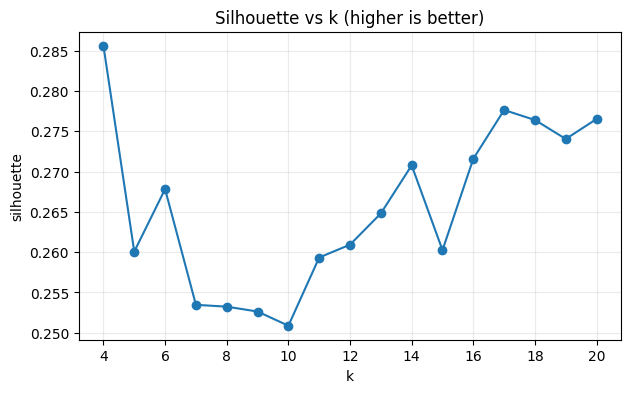

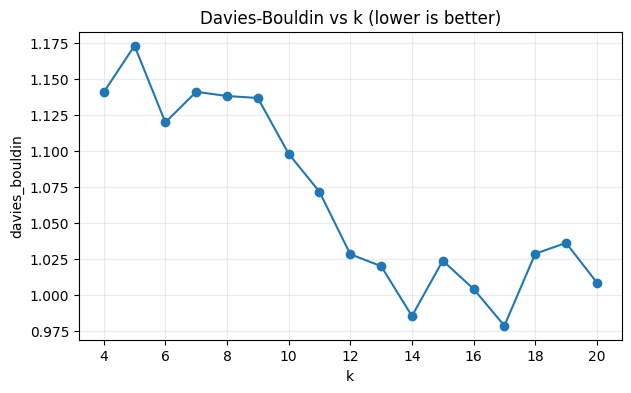

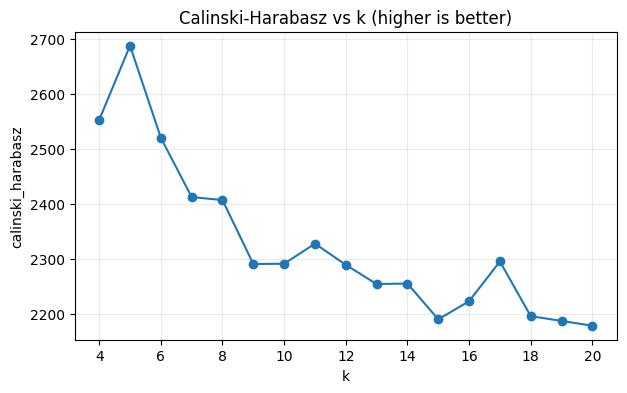

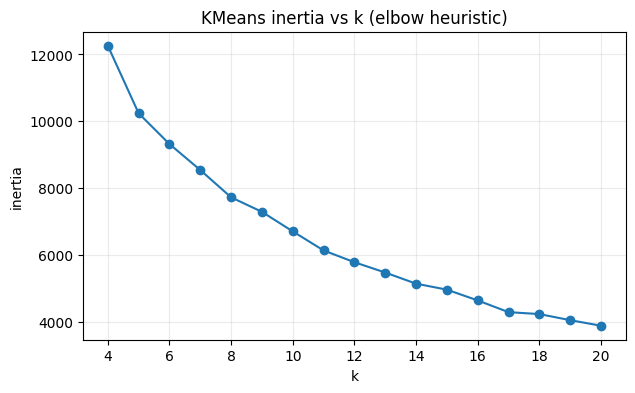

In [508]:

#Метод K_means
id, X = preproc("./data/S07-hw-dataset-02.csv")
k_values = list(range(4, 21))
sil, db, ch, inertia = compute_metrics_over_k(X, k_values)
# Визуализируем внутренние метрики + "локоть"
plt.figure(figsize=(7, 4))
plt.plot(k_values, sil, marker="o")
plt.title("Silhouette vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/Silhouette_vs_k_02.png', dpi=100)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, db, marker="o")
plt.title("Davies-Bouldin vs k (lower is better)")
plt.xlabel("k")
plt.ylabel("davies_bouldin")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, ch, marker="o")
plt.title("Calinski-Harabasz vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("calinski_harabasz")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, inertia, marker="o")
plt.title("KMeans inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.show()

Проанализировав графики метрик, выберем К=17. т.к при нем самые лучшие метрики. Довольно высокий силуэт относительно других К - 0.25, при этом хорошие
davies_bouldin_score
calinski_harabasz_score

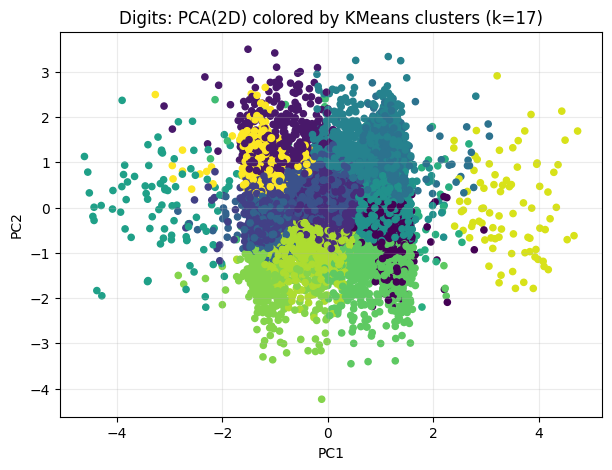

KMeans с k=17 - РЕЗУЛЬТАТЫ:
Silhouette score: 0.2827
Davies-Bouldin index: 0.9610
Calinski-Harabasz score: 2311
Inertia (WCSS): 4262


In [509]:
K = 17
model = KMeans(n_clusters=K,n_init=10,random_state=RANDOM_STATE)
labels = model.fit_predict(X)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, s=20)
plt.title(f"Digits: PCA(2D) colored by KMeans clusters (k={K})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/kmeans_pca_02.png', dpi=100)
plt.show()
sil_k = silhouette_score(X, labels)
db_k = davies_bouldin_score(X, labels)
ch_k = calinski_harabasz_score(X, labels)
inertia_k = model.inertia_

print_k_metrics(X,K,labels,model)

In [510]:
eps_list = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_list = [3, 5,6, 7,10,14]
best_params, results_df = grid_search_dbscan_simple(X, eps_list, min_samples_list)

# Обучаем финальную модель с лучшими параметрами
if best_params is not None:
    db_best = DBSCAN(eps=best_params['eps'], 
                     min_samples=int(best_params['min_samples']))
    labels_best = db_best.fit_predict(X)
    


DBSCAN с eps=0.7, min_samples=7 - РЕЗУЛЬТАТЫ:
Кластеров: 5
Шум: 1.7% (132 точек)
Silhouette: 0.3521
Davies-Bouldin: 0.8075
Calinski-Harabasz: 112


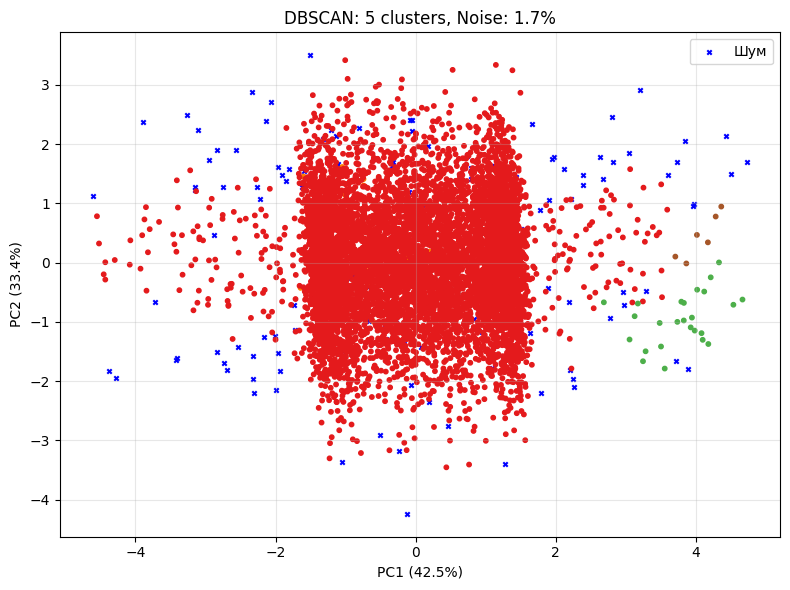

In [511]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))

# Шум
noise = labels_best == -1
if noise.any():
    plt.scatter(X_pca[noise, 0], X_pca[noise, 1], c='blue', s=10, marker='x', alpha=1, label='Шум')

# Кластеры
clusters = ~noise
plt.scatter(X_pca[clusters, 0], X_pca[clusters, 1], c=labels_best[clusters], s=10, cmap='Set1', alpha=1)

plt.grid(True, alpha=0.3)
plt.title(f'DBSCAN: {best_params["n_clusters"]} clusters, Noise: {best_params["noise_%"]:.1f}%')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend()
plt.tight_layout()
plt.show()

Итог: сравним 2 метода
Лучшие метрики DBSCAN:
eps: 0.7
min_samples: 7
Кластеров: 5
Шум: 1.7%
Silhouette: 0.352
Davies-Bouldin: 0.808
Calinski-Harabasz: 111.6

Лучшие метрики K_MEANS:

Silhouette score: 0.2827
Davies-Bouldin index: 0.9610
Calinski-Harabasz score: 2311
Inertia (WCSS): 4262

DBSCAN лучше по Silhouette: 0.352 против 0.2827 и Davies-Bouldin: 0.808 против 0.9610, но ЗНАЧИТЕЛЬНО хуже по Calinski-Harabasz 111.6 против 4262, что свидетельствует о слабом разделении кластеров в многомерном пространстве.

На основании этих выводов признаем лучшим методом K_means с K = 17

In [512]:
all_metrics['dataset_02']['kmeans'] = {
    'k': K,
    'silhouette': sil_k,
    'davies_bouldin': db_k,
    'calinski_harabasz': ch_k,
    'inertia': inertia_k
}

correct_dbscan_metrics = compute_dbscan_metrics(
    X, 
    eps=best_params['eps'], 
    min_samples=int(best_params['min_samples'])
)

all_metrics['dataset_02']['dbscan'] = correct_dbscan_metrics
all_metrics
df['label'] = labels_best
df.to_csv('artifacts/labels/labels_ hw07_ds2.csv', index=False)

# Работа с 3 датасетом

In [513]:
df = pd.read_csv("./data/S07-hw-dataset-03.csv")
df.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [515]:
df.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


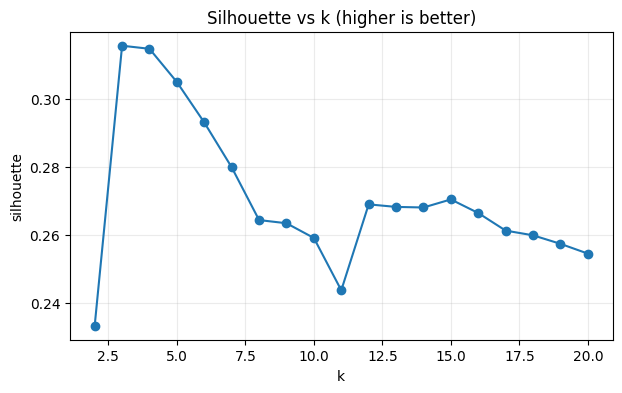

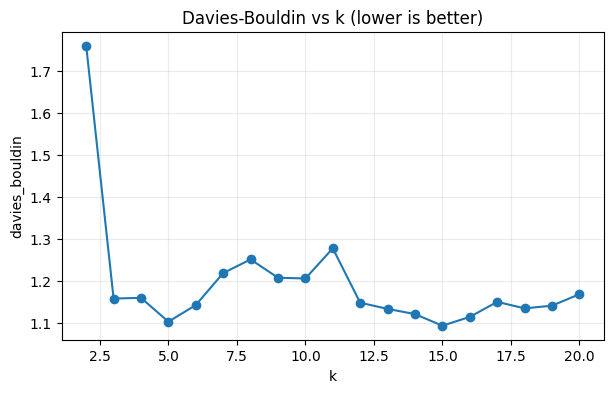

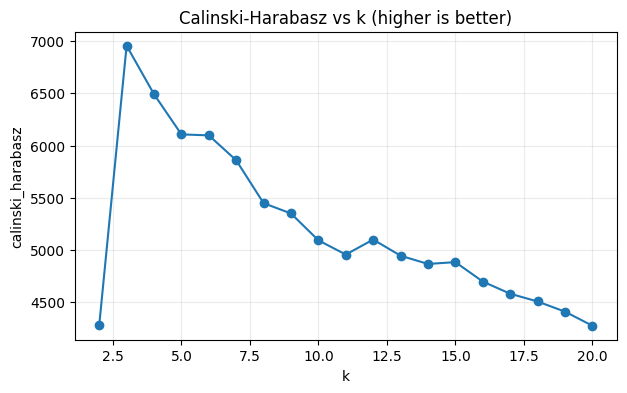

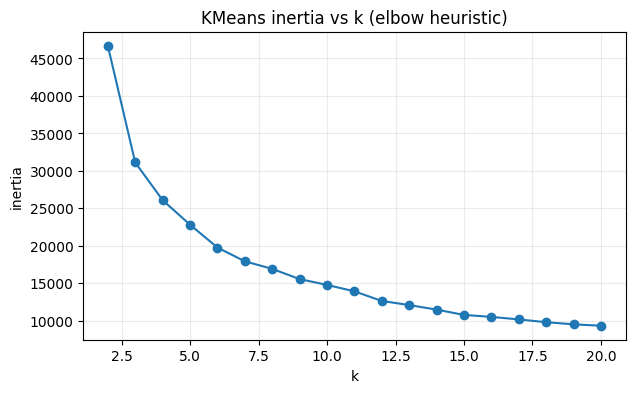

In [516]:
#Метод K_means
id, X = preproc("./data/S07-hw-dataset-03.csv")
k_values = list(range(2, 21))
sil, db, ch, inertia = compute_metrics_over_k(X, k_values)
# Визуализируем внутренние метрики + "локоть"
plt.figure(figsize=(7, 4))
plt.plot(k_values, sil, marker="o")
plt.title("Silhouette vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/Silhouette_vs_k_03.png', dpi=100)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, db, marker="o")
plt.title("Davies-Bouldin vs k (lower is better)")
plt.xlabel("k")
plt.ylabel("davies_bouldin")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, ch, marker="o")
plt.title("Calinski-Harabasz vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("calinski_harabasz")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, inertia, marker="o")
plt.title("KMeans inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.show()

Проанализировав графики метрик, выберем К=3. т.к при нем самые лучшие метрики. Довольно высокий силуэт относительно других К - 0.31, при этом хорошие
davies_bouldin_score
calinski_harabasz_score

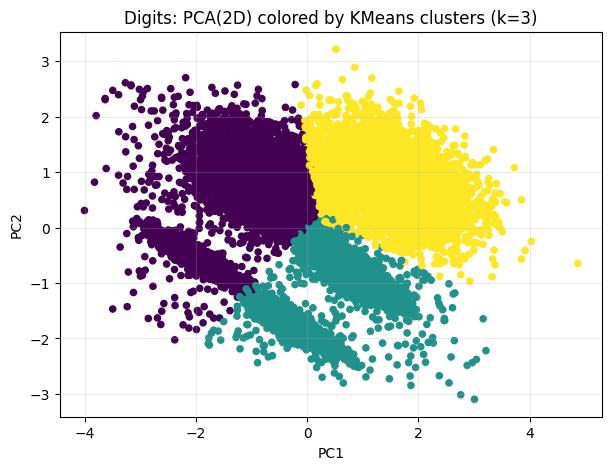

KMeans с k=3 - РЕЗУЛЬТАТЫ:
Silhouette score: 0.3155
Davies-Bouldin index: 1.1577
Calinski-Harabasz score: 6957
Inertia (WCSS): 31123


In [517]:
K = 3
model = KMeans(n_clusters=K,n_init=10,random_state=RANDOM_STATE)
labels = model.fit_predict(X)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, s=20)
plt.title(f"Digits: PCA(2D) colored by KMeans clusters (k={K})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/kmeans_pca_03.png', dpi=100)
plt.show()
sil_k = silhouette_score(X, labels)
db_k = davies_bouldin_score(X, labels)
ch_k = calinski_harabasz_score(X, labels)
inertia_k = model.inertia_

print_k_metrics(X,K,labels,model)

In [518]:
eps_list = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_list = [3, 5,6, 7,10,14]
best_params, results_df = grid_search_dbscan_simple(X, eps_list, min_samples_list)

# Обучаем финальную модель с лучшими параметрами
if best_params is not None:
    db_best = DBSCAN(eps=best_params['eps'], 
                     min_samples=int(best_params['min_samples']))
    labels_best = db_best.fit_predict(X)

DBSCAN с eps=0.7, min_samples=3 - РЕЗУЛЬТАТЫ:
Кластеров: 3
Шум: 0.3% (44 точек)
Silhouette: 0.2315
Davies-Bouldin: 0.5967
Calinski-Harabasz: 13


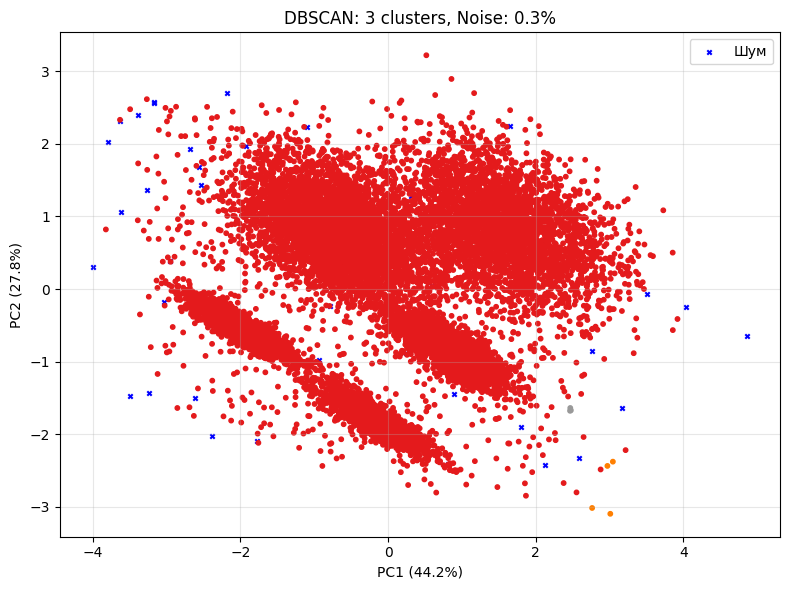

In [519]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))

# Шум
noise = labels_best == -1
if noise.any():
    plt.scatter(X_pca[noise, 0], X_pca[noise, 1], c='blue', s=10, marker='x', alpha=1, label='Шум')

# Кластеры
clusters = ~noise
plt.scatter(X_pca[clusters, 0], X_pca[clusters, 1], c=labels_best[clusters], s=10, cmap='Set1', alpha=1)

plt.grid(True, alpha=0.3)
plt.title(f'DBSCAN: {best_params["n_clusters"]} clusters, Noise: {best_params["noise_%"]:.1f}%')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend()
plt.tight_layout()
plt.show()

Итог: сравним 2 метода
Лучшие метрики DBSCAN:
eps=0.7, 
min_samples=3
Кластеров: 3
Шум: 0.3% (44 точек)
Silhouette: 0.2315
Davies-Bouldin: 0.5967
Calinski-Harabasz: 13

Лучшие метрики K_MEANS:

Silhouette score: 0.3155
Davies-Bouldin index: 1.1577
Calinski-Harabasz score: 6957
Inertia (WCSS): 31123


DBSCAN лучше по Davies-Bouldin: 0.5967 против 1.1577, но ЗНАЧИТЕЛЬНО, КАТАСТРОФИЧЕСКИ хуже по Calinski-Harabasz 13 против 6957, что свидетельствует об ОЧЕНЬ слабом разделении кластеров в многомерном пространстве. 

На основании этих выводов признаем лучшим методом K_means с K =3

In [520]:
all_metrics['dataset_03']['kmeans'] = {
    'k': K,
    'silhouette': sil_k,
    'davies_bouldin': db_k,
    'calinski_harabasz': ch_k,
    'inertia': inertia_k
}
correct_dbscan_metrics = compute_dbscan_metrics(
    X, 
    eps=best_params['eps'], 
    min_samples=int(best_params['min_samples'])
)

all_metrics['dataset_03']['dbscan'] = correct_dbscan_metrics
all_metrics
with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)

In [521]:
df['label'] = labels_best
df.to_csv('artifacts/labels/labels_ hw07_ds3.csv', index=False)

In [522]:
best_configs = {
    'dataset_01': {
        'best_method': 'dbscan',
        'criterion': 'silhouette (0.379 vs 0.355)',
        'params': all_metrics['dataset_01']['dbscan']
    },
    'dataset_02': {
        'best_method': 'kmeans', 
        'criterion': 'CH (111.6 vs 4262)',
        'params': all_metrics['dataset_02']['kmeans']
    },
    'dataset_03': {
        'best_method': 'kmeans',
        'criterion': 'CH(13 vs 6957),silhouette (0.31 vs 0.2315)',
        'params': all_metrics['dataset_03']['kmeans']
    }
}

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2, default=str)